In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

In [2]:
ds = load_dataset("google/MusicCaps")
df_train = ds['train'].to_pandas()
df_train['aspect_list_transformed'] = df_train['aspect_list'].apply(lambda x: x.strip("[]").replace("'", ""))
df_train['aspect_list_transformed'] = df_train['aspect_list_transformed'].apply(lambda x: x.split(', '))

README.md: 0.00B [00:00, ?B/s]

In [3]:
tag_counts = {}
for aspects in df_train['aspect_list_transformed']:
    for tag in aspects:
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1
tag_counts_df = pd.DataFrame(list(tag_counts.items()), columns=['Tag', 'Count'])
tag_counts_df = tag_counts_df.sort_values(by='Count', ascending=False)
tag_counts_df.to_csv('tags_counts_musiccaps.csv', index=False)

/tmp/ipykernel_26906/1042948098.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tag_counts_df, x='Tag', y='Count', palette='viridis')


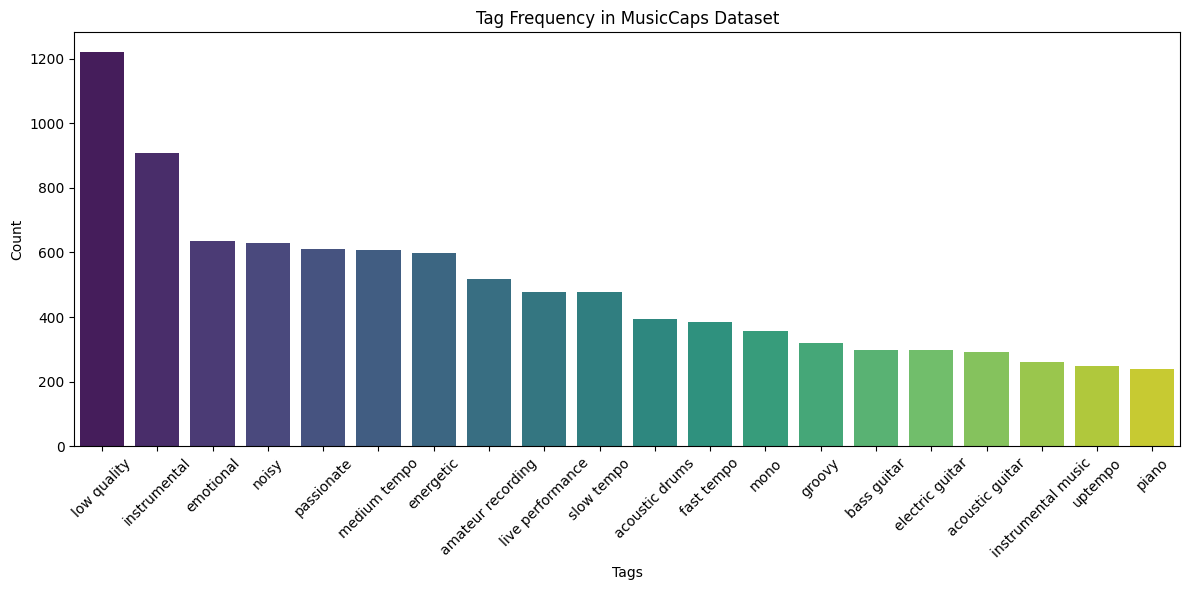

In [4]:
tag_counts_df = pd.read_csv('tags_counts_musiccaps.csv')
tag_counts_df = tag_counts_df.head(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=tag_counts_df, x='Tag', y='Count', palette='viridis')
plt.xticks(rotation=45)
plt.title('Tag Frequency in MusicCaps Dataset')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [5]:
tempo_tags = set([
    "fast tempo", "medium tempo", "slow tempo", "moderate tempo", "uptempo",
    "medium fast tempo", "slower tempo", "medium to uptempo", "mid-tempo",
    "quick tempo", "accelerated tempo", "steady tempo", "rapid tempo",
    "slow music", "very fast tempo", "slow to medium tempo", "medium-to-high pitch singing",
    "steady drumming rhythm", "dance rhythm", "various tempos", "tempo changes",
    "fast paced", "slow song", "mid tempo", "steady beat", "pulsating beats",
    "groovy rhythm", "4 on the floor kick pattern", "normal tempo", "fast beat"
])

genre_tags = set([
    "rock", "pop", "jazz", "classical", "folk", "blues", "hip hop", "reggae",
    "metal", "country", "r&b", "edm", "trance", "techno", "dance music",
    "electronic dance music", "gospel", "ambient", "soul", "funk",
    "alternative rock", "ballad", "hip-hop", "techno pop", "world music",
    "disco", "trap", "punk rock", "latin pop", "house", "bluegrass",
    "indie rock", "new age", "grunge", "industrial", "dubstep",
    "carnatic music", "bossa nova", "baroque music", "surf rock",
    "ska", "lo-fi", "symphonic", "orchestral", "fusion music", "raga",
    "bollywood music", "afrobeat", "folk song", "christian rock", "soundtrack"
])

mood_tags = set([
    "emotional", "passionate", "happy", "melancholic", "relaxing", "calming",
    "upbeat", "exciting", "mellow", "sentimental", "soothing", "joyful",
    "intense", "peaceful", "dreamy", "romantic mood", "ominous", "suspenseful",
    "haunting", "energetic", "chill", "cheerful", "nostalgic", "fun",
    "cool", "ethereal", "sad", "spooky", "hopeful", "playful",
    "mystical", "dark", "solemn", "festive", "inspirational", "sentimental",
    "powerful", "serene", "mysterious", "emphatic", "tranquil", "passionate singing",
    "ominous music", "romantic", "meditative", "joyous", "heartfelt", "uplifting",
    "enthusiastic", "melancholy", "emotional voice", "soothing melody", "heavenly", 
    "fearful", "vibrant", "soulful", "excited", "energetic drums", "charming"
])

instrument_tags = set([
    "piano", "drums", "guitar", "bass guitar", "electric guitar", "acoustic guitar",
    "flute", "violin", "cello", "trumpet", "saxophone", "tambourine",
    "synth", "harmonica", "organ", "harp", "clarinet", "string section",
    "percussion", "banjo", "trombone", "didgeridoo", "mandolin", "tabla",
    "ukulele", "accordion", "xylophone", "viola", "timpani", "congas",
    "bongo", "triangle", "oboe", "bagpipes", "steel drums", "marimba",
    "dj mixer", "drum machine", "brass section", "horn", "sitar",
    "strings", "keyboard", "double bass", "synth bass", "guitar solo",
    "electric piano", "acoustic piano", "woodwind", "cymbals", "bells",
    "vibraphone", "hand claps", "snare", "hi-hat", "kick drum", 
    "conga", "tabla percussion", "theremin", "church organ", "trumpets",
    "bass drum", "djembe", "steel guitar", "harpsichord", "choir"
])

In [6]:
def extract_tags(song_tags, concept_tags):
    res = []
    for c_tag in concept_tags:
        for s_tag in song_tags:
            if c_tag in s_tag:
                res.append(s_tag)
    return list(set(res))

In [7]:
concepts = {
    "tempo": tempo_tags,
    "genre": genre_tags,
    "mood": mood_tags,
    "instrument": instrument_tags
}

for concept, tags in concepts.items():
    df_train[concept + '_tags'] = df_train['aspect_list_transformed'].apply(
        lambda x: extract_tags(x, tags)
    )

In [8]:
df_train = df_train[["caption", "aspect_list_transformed", "tempo_tags", "genre_tags", "mood_tags", "instrument_tags"]]
df_train = df_train[(df_train['tempo_tags'].map(len) > 0) & 
                    (df_train['genre_tags'].map(len) > 0) & 
                    (df_train['mood_tags'].map(len) > 0) & 
                    (df_train['instrument_tags'].map(len) > 0)] 
df_train["aspect_list"] = df_train["aspect_list_transformed"].apply(lambda x: ', '.join(x))
df_train["tempo_tags"] = df_train["tempo_tags"].apply(lambda x: ', '.join(x))
df_train["genre_tags"] = df_train["genre_tags"].apply(lambda x: ', '.join(x))
df_train["mood_tags"] = df_train["mood_tags"].apply(lambda x: ', '.join(x))
df_train["instrument_tags"] = df_train["instrument_tags"].apply(lambda x: ', '.join(x))
df_train = df_train[["caption", "aspect_list", "tempo_tags", "genre_tags", "mood_tags", "instrument_tags"]]
df_train

,caption,aspect_list,tempo_tags,genre_tags,mood_tags,instrument_tags
1,This song features an electric guitar as the m...,"guitar song, piano backing, simple percussion,...",slow tempo,country feel,relaxing melody,"piano backing, guitar song, simple percussion"
11,This folk song features a male voice singing t...,"folk music, rubab, male voice, slow tempo, emo...",slow tempo,folk music,emotional song,"accordion, violin"
16,A male voice narrates a monologue to the rhyth...,"male vocalist, medium fast tempo, monologue, b...",medium fast tempo,"blues, classic rock and rock, rock and rock, r...",enthusiastic drumming,electric guitar
19,A children’s choir sings this devotional melod...,"gospel music, poor sound quality, children cho...","medium tempo, steady drumming rhythm","gospel music, black gospel music",meditative,"children choir, keyboard harmony"
24,This clip is an electronic guitar instrumental...,"instrumental, electric guitar, stringed instru...",fast tempo,"hard rock, rock",intense,"amplified guitar, electric guitar"
...,...,...,...,...,...,...
5501,This is a dancehall music piece. There is a ma...,"dancehall, reggae, dub, jamaican, male vocal, ...",medium-to-high pitch singing,reggae,"vibrant, chill",keyboard
5504,This is the live recording of a heavy metal mu...,"heavy metal, live performance, male vocal, pow...",fast tempo,heavy metal,"powerful singing, energetic","bass guitar, loud acoustic drums, electric guitar"
5509,This dance song features a female voice singin...,"dance song, club song, whistling sound, techno...",moderate tempo,techno beat,happy mood,"synth sounds, programmed percussion"
5517,The song is an instrumental. The song is mediu...,"instrumental music, arabic music, generational...",medium tempo,"folk musicians, ancient folk music, folk music...","passionate, emotional",percussion instruments


In [10]:
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(df_train, test_size=0.1, random_state=42)
os.makedirs('../data/musiccaps_with_concept_tags', exist_ok=True)
df_train.to_csv('../data/musiccaps_with_concept_tags/train.csv', index=False)
df_valid.to_csv('../data/musiccaps_with_concept_tags/valid.csv', index=False)